In [337]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import AveragePooling2D,Input,Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

uint8
(350, 525, 3)


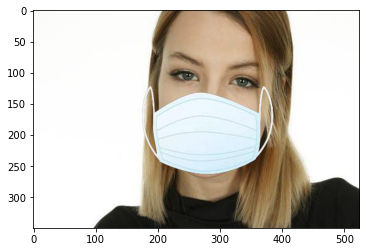

In [25]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('./Dataset/test/with_mask/1-with-mask.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

# Convolutional Neural Network

In [405]:
#Function to use when working with file directory
DIR = './Dataset/'
CATEGORIES = ['train/with_mask', 'train/without_mask', 'test/with_mask', 'test/without_mask']

def data_preparation(DIR, CATEGORIES):
    training_data = []
    for i in CATEGORIES:
        path = os.path.join(DIR, i)
        class_num = CATEGORIES.index(i)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (224, 224))
            training_data.append([new_array, class_num])
    return training_data

In [323]:
# Get Train and Test Data (into array form), using glob library makes the work easier
import glob
#Train Dataset 
train_mon = [cv2.imread(file) for file in glob.glob("./Dataset/train/with_mask/*.jpg")]
train_moff = [cv2.imread(file) for file in glob.glob("./Dataset/train/without_mask/*.jpg")]
#Test Dataset
test_mon = [cv2.imread(file) for file in glob.glob("./Dataset/test/with_mask/*.jpg")]
test_moff = [cv2.imread(file) for file in glob.glob("./Dataset/test/without_mask/*.jpg")]

In [325]:
# Resizing every image and assign label
train_1 = []
for i in range(len(train_mon)):
    resized = cv2.resize(train_mon[i], (224,224), interpolation = cv2.INTER_LINEAR)
    train_1.append((resized, 1))
    
train_0 = []
for i in range(len(train_moff)):
    resized = cv2.resize(train_moff[i], (224,224), interpolation = cv2.INTER_LINEAR)
    train_0.append((resized, 0))

test_1 = []
for i in range(len(test_mon)):
    resized = cv2.resize(test_mon[i], (224,224), interpolation = cv2.INTER_LINEAR)
    test_1.append((resized, 1))
    
test_0 = []
for i in range(len(test_moff)):
    resized = cv2.resize(test_moff[i], (224,224), interpolation = cv2.INTER_LINEAR)
    test_0.append((resized, 0))

In [326]:
#Combine Binary class Train and Test dataset and shuffle them 
train = train_1 + train_0
test = test_1 + test_0

import random
random.shuffle(train)
random.shuffle(test)

In [327]:
train_1[0][0].shape

(224, 224, 3)

In [328]:
X_train = np.array([train[i][:-1][0] for i in range(len(train))])
y_train = pd.get_dummies([train[i][-1] for i in range(len(train))])

X_test = np.array([test[i][:-1][0] for i in range(len(test))])
y_test = pd.get_dummies([test[i][-1] for i in range(len(test))])

In [329]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1294, 224, 224, 3)
(1294, 2)
(194, 224, 224, 3)
(194, 2)


In [330]:
#Normalizing the data - To have mean of 0 
X_train = X_train/255
X_test = X_test/255

### Trying Simple Convolutional Neural Network

In [331]:
model = Sequential()

model.add(Conv2D(100, kernel_size = (3,3), input_shape=(224,224,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(100, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dense(2, activation = 'softmax'))
print(model.summary())

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 222, 222, 100)     2800      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 111, 111, 100)     0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 109, 109, 100)     90100     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 54, 54, 100)       0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 291600)            0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 291600)            0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)              

In [305]:
history = model.fit(X_train,y_train, batch_size= 10, epochs = 5, validation_data=(X_test, y_test))

Epoch 1/5
130/130 [==============================] - 48s 364ms/step - loss: 0.5103 - accuracy: 0.8199 - val_loss: 0.2035 - val_accuracy: 0.9278
Epoch 2/5
130/130 [==============================] - 46s 354ms/step - loss: 0.1622 - accuracy: 0.9482 - val_loss: 0.1831 - val_accuracy: 0.9485
Epoch 3/5
130/130 [==============================] - 50s 385ms/step - loss: 0.2329 - accuracy: 0.9142 - val_loss: 0.4090 - val_accuracy: 0.8299
Epoch 4/5
130/130 [==============================] - 46s 353ms/step - loss: 0.1833 - accuracy: 0.9359 - val_loss: 0.2145 - val_accuracy: 0.9433
Epoch 5/5
130/130 [==============================] - 44s 342ms/step - loss: 0.1735 - accuracy: 0.9382 - val_loss: 0.4018 - val_accuracy: 0.8763


Clearly validation loss is showing overfitting, loss fluctuates but eventually increase and training accuracy increase with loss decrease

# Transfer Learning

In [310]:
#Importing Keras pretrained model (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2

In [311]:
#Initialize Hyperparameters
learning_rate = 1e-4
Epochs = 10
batch_size = 10

In [333]:
#Include_top = False allows removal of Fully Connected layer so that we can replace it wiht out FC layer
baseModel = MobileNetV2(weights='imagenet', include_top = False, input_shape = (224,224,3))

top = baseModel.output
top = AveragePooling2D(pool_size = (7,7), padding="same")(top)
top = Flatten(name = 'flatten')(top)
top = Dense(128, activation = 'relu')(top)
top = Dropout(0.5)(top)
top = Dense(2, activation = 'softmax')(top)

model = Model(inputs = baseModel.input, outputs = top)

In [334]:
#Freezing the Convolutional Layers (pretrained)
for layer in baseModel.layers:
    layer.trainable = False

In [336]:
# Pretrained Model includes Deep Neural Nets
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [339]:
# opt = Adam(lr= learning_rate, decay = learning_rate)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [416]:
ml = model.fit(X_train, y_train, batch_size = batch_size, validation_data=(X_test, y_test),
         epochs = 5)

Epoch 1/5
130/130 [==============================] - 27s 205ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 7.5809e-04 - val_accuracy: 1.0000
Epoch 2/5
130/130 [==============================] - 26s 199ms/step - loss: 0.0220 - accuracy: 0.9938 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 3/5
130/130 [==============================] - 26s 203ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0074 - val_accuracy: 0.9948
Epoch 4/5
130/130 [==============================] - 27s 204ms/step - loss: 0.0091 - accuracy: 0.9977 - val_loss: 6.6410e-04 - val_accuracy: 1.0000
Epoch 5/5
130/130 [==============================] - 28s 212ms/step - loss: 0.0329 - accuracy: 0.9915 - val_loss: 0.0023 - val_accuracy: 1.0000


In [398]:
y_true = []
for i in y_test.values:
    y_true.append(np.argmax(i))

In [403]:
from sklearn.metrics import classification_report
prediction = model.predict(X_test)
pred_idx = np.argmax(prediction, axis = 1)
print(classification_report(np.array(y_true),pred_idx))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        97

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194



# Conclusion
1. For Convolutional Neural network, there are many online pretrained model that can nullify the intense computation and make better classification performance
2. Transfer Learning showed much more accurate and faster computation.

In [427]:
model.predict(X_test[1:2])[0]

array([1.2929415e-15, 1.0000000e+00], dtype=float32)

In [432]:
X_test[1:2].shape

(1, 224, 224, 3)

In [430]:
np.argmax(X_test[1:2][0])

1

In [442]:
class_pred = np.argmax(model.predict(X_test[1:2]))

In [443]:
class_pred

1

In [444]:
if class_pred == 1:
    print('Mask On')
else:
    print('Maks Off')
    

Mask On


In [446]:
y_test

,0,1
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
189,0,1
190,1,0
191,1,0
192,1,0
